# <font  color = "#0093AF"> $T_1$ and NOE

SLEEPY can simulate $T_1$ relaxation due to exchange dynamics, but requires being run in the lab frame. Modulation of a CSA will yield relaxation of one spin, whereas modulation of a dipole coupling will also bring about a polarization transfer between the spins (Nuclear Overhauser Effect).

In [0]:
# SETUP SLEEPY
!git clone https://github.com/alsinmr/SLEEPY.git

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ex0=sl.ExpSys(v0H=600,Nucs='13C',vr=0,LF=True,pwdavg=sl.PowderAvg())
ex0.set_inter('CSA',i=0,delta=200)
ex1=ex0.copy()
ex1.set_inter('CSA',i=0,delta=200,euler=[0,45*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(1e-10)

seq=L.Sequence(Dt=1e-2)

rho=sl.Rho('Thermal','13Cz')

rho.DetProp(seq,n=1000)

Density Matrix/Detection Operator
rho0: Thermal
detect[0]: 13Cz
Current time is 10000000.000 microseconds
1000 time points have been recorded


<AxesSubplot:xlabel='t / ms', ylabel='<$^{13}C_z$>'>

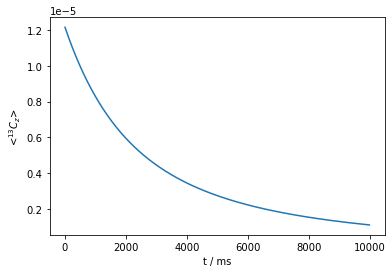

In [4]:
rho.plot()

In [114]:
ex0=sl.ExpSys(v0H=600,Nucs=['13C','1H'],vr=0,LF=True,pwdavg=sl.PowderAvg()[10])
ex0.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.109,'1H','13C'))
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.109,'1H','13C'),euler=[0,45*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(1e-12)

L.add_relax('DynamicThermal')

seq=L.Sequence(Dt=1e-4)
U=seq.U()**100

rho=sl.Rho('Thermal',['1Hz','13Cz'])
# L.Udelta('1H',np.pi)*rho

rho.DetProp(U,n=50000)

Density Matrix/Detection Operator
rho0: Thermal
detect[0]: 1Hz
detect[1]: 13Cz
Current time is 500000000.000 microseconds
50000 time points have been recorded


/Users/albertsmith/Documents/GitHub.nosync/SLEEPY/Rho.py:1267: UserWarning: Dynamic thermal may not be stable with exchange rates and relaxation matrix separated by more than 10 orders of magnitude
  warnings.warn('Dynamic thermal may not be stable with exchange rates and relaxation matrix separated by more than 10 orders of magnitude')
/Users/albertsmith/Documents/GitHub.nosync/SLEEPY/Rho.py:1267: UserWarning: Dynamic thermal may not be stable with exchange rates and relaxation matrix separated by more than 10 orders of magnitude
  warnings.warn('Dynamic thermal may not be stable with exchange rates and relaxation matrix separated by more than 10 orders of magnitude')


<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

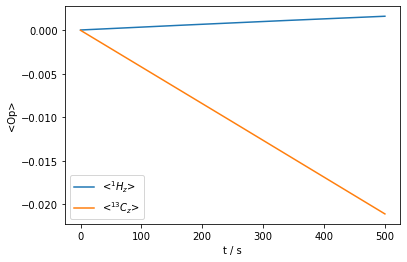

In [115]:
rho.plot(axis='s')

In [99]:
rho._detect[0]@((np.linalg.pinv(L[0].L(0))@L[0].L(0))@L.rho_eq(sub1=True))

(2.745649944372181e-23+2.0069756583066677e-27j)

In [41]:
n=np.argmax(U._eig[0][0].real)
v=U._eig[0][1]
vi=np.linalg.pinv(v)
mat=np.atleast_2d(v[:,n]).T@np.atleast_2d(vi[n])

In [42]:
(rho._detect[0]@(mat@rho._rho0[0]))

(4.6098570604780065e-05-1.5298573018699566e-13j)

In [43]:
ex0.Peq

array([1.21512887e-05, 4.83145275e-05])

In [44]:
(np.abs(U._eig[0][0])>1e-10).sum()

16

In [45]:
U._eig[0][0]

array([-0.87317894+4.69546101e-01j, -0.87317895-4.69546105e-01j,
       -0.72939939-6.71483801e-01j, -0.7293994 +6.71483806e-01j,
       -0.79821696+5.88017246e-01j,  0.99151681-1.08674541e-01j,
       -0.81682276+5.61885199e-01j,  0.98720425-1.40655962e-01j,
       -0.79821696-5.88017246e-01j, -0.81682277-5.61885202e-01j,
        0.99151681+1.08674547e-01j,  0.98720424+1.40655956e-01j,
        1.        +1.87033891e-15j,  0.99983054-5.41378598e-16j,
        0.99500008-1.91883320e-15j,  0.99444054+4.55627374e-15j,
        0.        +0.00000000e+00j, -0.        -0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, -0.        -0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
       -0.        +0.00000000e+00j, -0.        -0.00000000e+00j,
        0.        -0.0000

In [48]:
U._eig[0][0][12]

(1.000000004668621+1.8703389132142916e-15j)